# Autoregressive Image Generation without Vector Quantization

This notebook samples from pre-trained MAR+DiffLoss models, which are class-conditional masked autoregressive models trained on ImageNet to model continuous latent tokens. MAR+DiffLoss achieves state-of-the-art performance on the ImageNet benchmarks. A large portion of this demo is adopted from [DiT](https://github.com/facebookresearch/DiT).

[Paper](https://arxiv.org/abs/2406.11838) | [GitHub](https://github.com/LTH14/mar)

# 1. Setup

We recommend using GPUs (Runtime > Change runtime type > Hardware accelerator > GPU). Run this cell to clone the MAR GitHub repo and setup PyTorch. You only have to run this once.

In [ ]:
import os

!git clone https://github.com/LTH14/mar.git
import os
os.chdir('mar')
os.environ['PYTHONPATH'] = '/env/python:/content/mar'
!pip install timm==0.9.12
# MAR imports:
import torch
import numpy as np
from models import mar
from models.vae import AutoencoderKL
from torchvision.utils import save_image
from util import download
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

# Download Pre-trained VAE

In [2]:
download.download_pretrained_vae()

# 2. Load and download pre-trained MAR models

In [ ]:
model_type = "mar_huge" #@param ["mar_base", "mar_large", "mar_huge"]
num_sampling_steps_diffloss = 100 #@param {type:"slider", min:1, max:1000, step:1}
if model_type == "mar_base":
  download.download_pretrained_marb(overwrite=False)
  diffloss_d = 6
  diffloss_w = 1024
elif model_type == "mar_large":
  download.download_pretrained_marl(overwrite=False)
  diffloss_d = 8
  diffloss_w = 1280
elif model_type == "mar_huge":
  download.download_pretrained_marh(overwrite=False)
  diffloss_d = 12
  diffloss_w = 1536
else:
  raise NotImplementedError
model = mar.__dict__[model_type](
  buffer_size=64,
  diffloss_d=diffloss_d,
  diffloss_w=diffloss_w,
  num_sampling_steps=str(num_sampling_steps_diffloss)
).to(device)
state_dict = torch.load("pretrained_models/mar/{}/checkpoint-last.pth".format(model_type))["model_ema"]
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL(embed_dim=16, ch_mult=(1, 1, 2, 2, 4), ckpt_path="pretrained_models/vae/kl16.ckpt").cuda().eval()

# 3. Sample from Pre-trained MAR Models

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/).

100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


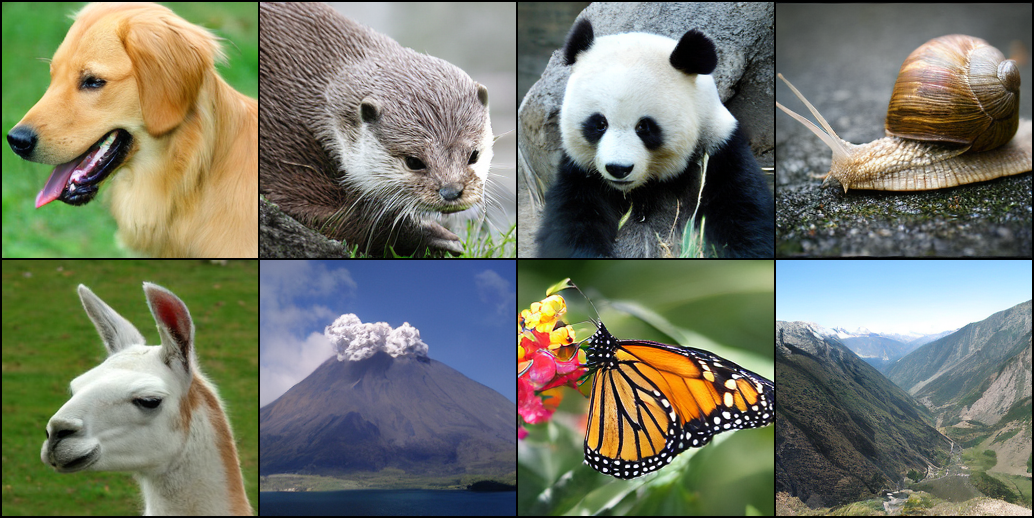

In [5]:
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
np.random.seed(seed)
num_ar_steps = 64 #@param {type:"slider", min:1, max:256, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
cfg_schedule = "constant" #@param ["linear", "constant"]
temperature = 1.0 #@param {type:"slider", min:0.9, max:1.1, step:0.01}
class_labels = 207, 360, 388, 113, 355, 980, 323, 979 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

with torch.cuda.amp.autocast():
  sampled_tokens = model.sample_tokens(
      bsz=len(class_labels), num_iter=num_ar_steps,
      cfg=cfg_scale, cfg_schedule=cfg_schedule,
      labels=torch.Tensor(class_labels).long().cuda(),
      temperature=temperature, progress=True)
  sampled_images = vae.decode(sampled_tokens / 0.2325)

# Save and display images:
save_image(sampled_images, "sample.png", nrow=int(samples_per_row), normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)